# MARATONA BEHIND THE CODE 2020

## DESAFIO 4 - CompuSoluciones
### Solución Luis Marquez

### Introducción

En este desafío, CompuSoluciones usará herramientas de IBM como Watson Studio (o Cloud Pack for Data) y Watson Machine Learning para construir un modelo de Machine Learning natural capaz de predecir la probabilidad de cumplimiento de pago.

La idea esencial del Desafío 4 es crear un modelo basado en machine learning capaz de identificar el comportamiento financiero del asociado de negocio, permitiendo una probabilidad de cumplimiento o incumplimiento del crédito.

### En este Notebook, se encuentra parte del codigo proporcionado por los organizadores para la resolución del desafio junto con mis modificaciones y añadidos personales para resolverlo, así como todos los comentarios que hago a titulo ilustrativo sobre mi solucion particular y los conceptos que manejo.

<hr>

### Instalación de Librerias

In [1]:
!pip install scikit-learn --upgrade

Requirement already up-to-date: scikit-learn in c:\users\luis marquez\appdata\local\programs\python\python38-32\lib\site-packages (0.23.2)

You should consider upgrading via the 'c:\users\luis marquez\appdata\local\programs\python\python38-32\python.exe -m pip install --upgrade pip' command.


In [4]:
import requests
import pandas as pd
import numpy as np
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request

### Descargando el dataset csv desde Github

In [5]:
url = 'https://raw.githubusercontent.com/vanderlei-test/dataset/master/reto-4-compu-train.csv'
filename = 'reto-4-compu-train.csv'
urllib.request.urlretrieve(url, filename)

('reto-4-compu-train.csv', <http.client.HTTPMessage at 0x5936d60>)

In [6]:
df = pd.read_csv(r'reto-4-compu-train.csv')
df.head()

,EFECTIVO,CXC,INVENTARIO,EQ_OFICINA,EQ_TRANSPORTE,TERRENOS_Y_CONSTRUCCIONES,CXP,CONTRIBUCIONES_X_PAGAR,ANTICIPOS_CTE,CAP_SOCIAL,UTILIDADES_ACUMULADAS,UTILIDAD_O_PERDIDA,TOTAL_VENTAS,TOTAL_COMPRAS,UTILIDAD_BRUTA,TOTAL_GASTOS,OBJETIVO
0,NaN,7.710800e+06,NaN,1.237449e+06,2.947057e+05,8.812520e+06,4.547214e+07,239671.50090,1.257907e+06,2356497.733,-6.009930e+06,-6.816681e+06,41309820.53,6.872572e+07,6298390.104,1.505762e+07,Aceptado
1,7.437098e+04,2.213116e+06,NaN,1.335531e+05,4.000109e+05,8.491851e+06,1.573254e+07,94809.20697,6.708985e+05,NaN,-7.980962e+06,-3.342452e+06,NaN,3.588274e+07,NaN,1.085156e+07,Aceptado
2,5.269987e+06,2.893119e+07,3.983352e+05,1.533061e+07,3.478673e+06,-1.393229e+07,NaN,610814.63990,1.009937e+07,1444426.243,NaN,-4.026344e+06,NaN,3.292337e+08,NaN,8.680735e+06,Sospechoso
3,9.092134e+05,1.145092e+07,9.577823e+06,1.068692e+06,1.302021e+06,1.379064e+06,NaN,NaN,2.378928e+06,1236065.779,NaN,-4.567435e+06,76310275.60,NaN,NaN,1.323267e+07,Aceptado
4,9.688669e+05,8.539206e+06,3.898283e+06,4.168733e+05,NaN,-6.297179e+05,7.620711e+06,116647.73960,1.798065e+06,3657339.603,7.702845e+05,-7.110320e+05,62901614.29,3.614260e+07,6850340.403,1.100048e+07,Aceptado


### Acerca del Dataset

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9400 entries, 0 to 9399
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   EFECTIVO                   7986 non-null   float64
 1   CXC                        7968 non-null   float64
 2   INVENTARIO                 8000 non-null   float64
 3   EQ_OFICINA                 7945 non-null   float64
 4   EQ_TRANSPORTE              7988 non-null   float64
 5   TERRENOS_Y_CONSTRUCCIONES  8038 non-null   float64
 6   CXP                        7934 non-null   float64
 7   CONTRIBUCIONES_X_PAGAR     8052 non-null   float64
 8   ANTICIPOS_CTE              7976 non-null   float64
 9   CAP_SOCIAL                 8036 non-null   float64
 10  UTILIDADES_ACUMULADAS      7993 non-null   float64
 11  UTILIDAD_O_PERDIDA         8031 non-null   float64
 12  TOTAL_VENTAS               7941 non-null   float64
 13  TOTAL_COMPRAS              7908 non-null   float

Las variables son todas numericas. Solo nuestra variable OBJETIVO (Prestamo aprobado o posible incumplimiento financiero) es the tipo object.

La función describe() de abajo muestra varias estadisticas del dataset.

In [8]:
df.describe()

,EFECTIVO,CXC,INVENTARIO,EQ_OFICINA,EQ_TRANSPORTE,TERRENOS_Y_CONSTRUCCIONES,CXP,CONTRIBUCIONES_X_PAGAR,ANTICIPOS_CTE,CAP_SOCIAL,UTILIDADES_ACUMULADAS,UTILIDAD_O_PERDIDA,TOTAL_VENTAS,TOTAL_COMPRAS,UTILIDAD_BRUTA,TOTAL_GASTOS
count,7.986000e+03,7.968000e+03,8.000000e+03,7.945000e+03,7.988000e+03,8.038000e+03,7.934000e+03,8.052000e+03,7.976000e+03,8.036000e+03,7.993000e+03,8.031000e+03,7.941000e+03,7.908000e+03,7.971000e+03,7.943000e+03
mean,1.720915e+06,1.561073e+07,1.098941e+07,4.341284e+06,1.321588e+06,6.198420e+05,2.275234e+07,4.109997e+05,2.635145e+06,3.325138e+06,4.240122e+06,-2.090086e+06,1.017051e+08,1.211510e+08,1.702067e+07,1.620236e+07
std,5.958844e+06,1.980334e+07,1.541956e+07,1.885512e+07,1.398674e+06,6.202347e+06,2.810091e+07,6.311683e+05,3.828127e+06,4.122756e+06,1.066916e+07,2.439421e+06,1.148423e+08,3.320798e+08,1.710116e+07,1.341951e+07
min,2.591455e+03,3.282261e+01,5.019700e-02,2.974216e+02,1.698222e+02,-1.577708e+07,1.276200e+01,5.638191e+03,4.495763e+00,2.334091e+00,-4.029189e+07,-8.716171e+06,7.154203e+03,1.458903e+05,2.408107e+03,3.979024e+03
25%,1.874601e+05,2.362067e+06,9.281351e+05,1.769855e+05,3.433503e+05,-3.874056e+06,3.711720e+06,1.113298e+05,3.813363e+05,5.629920e+05,-3.025772e+06,-3.824858e+06,2.303181e+07,1.214764e+07,4.836037e+06,6.104123e+06
50%,5.112329e+05,8.255125e+06,4.810330e+06,6.529255e+05,8.630635e+05,1.828932e+06,1.286143e+07,2.288855e+05,1.235872e+06,1.870131e+06,4.119952e+06,-1.629044e+06,6.309045e+07,3.473485e+07,1.181114e+07,1.272461e+07
75%,1.432613e+06,2.160462e+07,1.474278e+07,2.430901e+06,1.827559e+06,5.955197e+06,3.097250e+07,4.690705e+05,3.273238e+06,4.536913e+06,1.140550e+07,-7.368186e+03,1.378293e+08,1.007433e+08,2.352766e+07,2.260017e+07
max,3.343603e+08,2.135761e+08,1.664338e+08,5.913821e+08,1.290365e+07,9.031323e+06,2.644946e+08,1.618323e+07,4.291686e+07,4.116688e+07,4.056842e+07,1.214191e+06,1.151511e+09,1.000136e+10,1.438985e+08,9.763166e+07


In [9]:
#conteo de muestras en las categorias de objetivo, se ve un desbalance muy grande entre ambas por lo que se hara un resampling para balancear un poco la muestra y mejorar el modelo
from collections import Counter

print(Counter(df['OBJETIVO']))

Counter({'Aceptado': 8873, 'Sospechoso': 527})


c:\users\luis marquez\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\luis marquez\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\luis marquez\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments witho

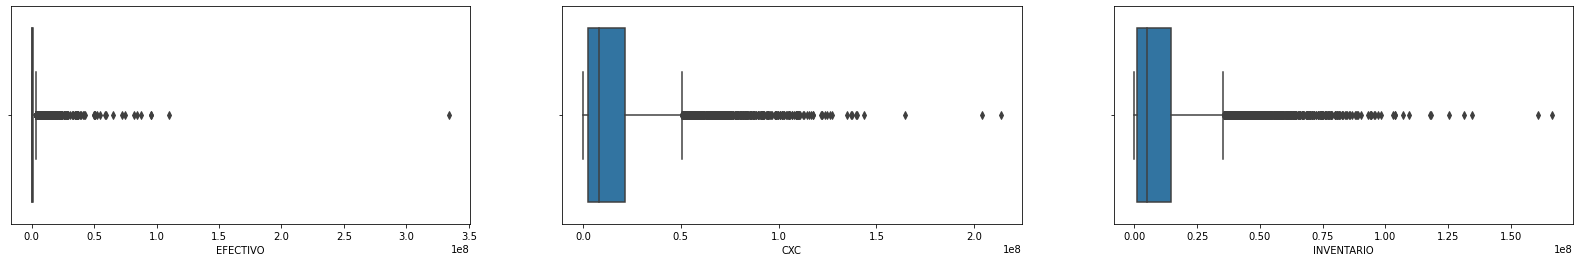

In [10]:
#hacemos una grafica de cajas para verificar la posible presencia de Outliers
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(28, 4))

sns.boxplot(df['EFECTIVO'].dropna(), ax=axes[0])
sns.boxplot(df['CXC'].dropna(), ax=axes[1])
sns.boxplot(df['INVENTARIO'].dropna(), ax=axes[2])
plt.show()

#Se puede ver que existen outliers en el dataset que podrian ser eliminados para mejorar un poco el modelo (como ejemplo se muestran 3 pero se puede verificar que en todas existen outliers)

In [11]:
print("Valores nulos del df_training_dataset despues de la transformación SimpleImputer: \n\n{}\n".format(df.isnull().sum(axis = 0)))

Valores nulos del df_training_dataset despues de la transformación SimpleImputer: 

EFECTIVO                     1414
CXC                          1432
INVENTARIO                   1400
EQ_OFICINA                   1455
EQ_TRANSPORTE                1412
TERRENOS_Y_CONSTRUCCIONES    1362
CXP                          1466
CONTRIBUCIONES_X_PAGAR       1348
ANTICIPOS_CTE                1424
CAP_SOCIAL                   1364
UTILIDADES_ACUMULADAS        1407
UTILIDAD_O_PERDIDA           1369
TOTAL_VENTAS                 1459
TOTAL_COMPRAS                1492
UTILIDAD_BRUTA               1429
TOTAL_GASTOS                 1457
OBJETIVO                        0
dtype: int64



Feature: 0, Score: 0.04744
Feature: 1, Score: 0.04523
Feature: 2, Score: 0.06580
Feature: 3, Score: 0.03521
Feature: 4, Score: 0.02955
Feature: 5, Score: 0.11853
Feature: 6, Score: 0.03547
Feature: 7, Score: 0.02783
Feature: 8, Score: 0.06613
Feature: 9, Score: 0.03602
Feature: 10, Score: 0.09763
Feature: 11, Score: 0.14174
Feature: 12, Score: 0.06925
Feature: 13, Score: 0.03873
Feature: 14, Score: 0.08552
Feature: 15, Score: 0.05994


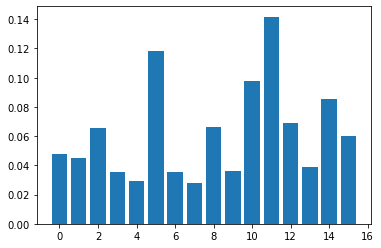

In [12]:
#Celda para observar la importancia de los features en el dataframe de manera de saber que columnas eliminar
#utilizamos un mode de Random Forest sencillo para obtener el metodo feature_importances
from sklearn.ensemble import RandomForestClassifier
dftest = df.dropna()
target = dftest['OBJETIVO']
model = RandomForestClassifier()
# fit the model
model.fit(dftest.drop(columns=['OBJETIVO']), target)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [13]:
dftest.columns

Index(['EFECTIVO', 'CXC', 'INVENTARIO', 'EQ_OFICINA', 'EQ_TRANSPORTE',
       'TERRENOS_Y_CONSTRUCCIONES', 'CXP', 'CONTRIBUCIONES_X_PAGAR',
       'ANTICIPOS_CTE', 'CAP_SOCIAL', 'UTILIDADES_ACUMULADAS',
       'UTILIDAD_O_PERDIDA', 'TOTAL_VENTAS', 'TOTAL_COMPRAS', 'UTILIDAD_BRUTA',
       'TOTAL_GASTOS', 'OBJETIVO'],
      dtype='object')

In [14]:
#En esta celda eliminamos los valores nulos de algunas columnas, las 3 que tienen mayor relevancia en el modelo
print("verificando que no se haya modificado el df: \n\n{}\n".format(df.isnull().sum(axis = 0)))
print(Counter(df['OBJETIVO']))
df = df.dropna(axis='index', how='any', subset=['TERRENOS_Y_CONSTRUCCIONES','UTILIDADES_ACUMULADAS','UTILIDAD_O_PERDIDA'])
print(Counter(df['OBJETIVO']))
print("Valores nulos del df despues de la transformación dropna: \n\n{}\n".format(df.isnull().sum(axis = 0)))

verificando que no se haya modificado el df: 

EFECTIVO                     1414
CXC                          1432
INVENTARIO                   1400
EQ_OFICINA                   1455
EQ_TRANSPORTE                1412
TERRENOS_Y_CONSTRUCCIONES    1362
CXP                          1466
CONTRIBUCIONES_X_PAGAR       1348
ANTICIPOS_CTE                1424
CAP_SOCIAL                   1364
UTILIDADES_ACUMULADAS        1407
UTILIDAD_O_PERDIDA           1369
TOTAL_VENTAS                 1459
TOTAL_COMPRAS                1492
UTILIDAD_BRUTA               1429
TOTAL_GASTOS                 1457
OBJETIVO                        0
dtype: int64

Counter({'Aceptado': 8873, 'Sospechoso': 527})
Counter({'Aceptado': 5501, 'Sospechoso': 329})
Valores nulos del df despues de la transformación dropna: 

EFECTIVO                     851
CXC                          885
INVENTARIO                   888
EQ_OFICINA                   905
EQ_TRANSPORTE                917
TERRENOS_Y_CONSTRUCCIONES      0
CXP      

<hr>

### Entrenamiento y evaluación de un modelo de clasificación binaria


#### En las siguientes celdas vamos definiendo y aplicando algunas atransformaciones para ir acondicionando los datos a ser introducidos al modelo

Utilizamos transformaciones personalizadas de Sklearn, las mismas usadas en el desafio 2. Asi como algunas mas.

In [15]:
!pip install imbalanced-learn

You should consider upgrading via the 'c:\users\luis marquez\appdata\local\programs\python\python38-32\python.exe -m pip install --upgrade pip' command.


In [16]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin


# All sklearn Transforms must have the `transform` and `fit` methods
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Primero copiamos el dataframe de datos de entrada 'X'
        data = X.copy()
        # Devolvemos un nuevo dataframe de datos sin las columnas no deseadas
        return data.drop(labels=self.columns, axis='columns')

In [18]:
#transformacion personalizada para eliminar outliers y aplicar simple imputer al mismo tiempo

class OutlierExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        print('init')

    def fit(self, X, Y):
        return self

    def transform(self, X, Y):
        # Primero copiamos el dataframe de datos de entrada 'X'
        X2 = si.fit_transform(X)
        Y2 = Y.to_numpy()
        iso = IsolationForest(n_estimators=200,contamination=0.3,random_state=42)
        yhat = iso.fit_predict(X2)
        mask = yhat != -1
        X2, Y2 = X2[mask, :], Y2[mask]
        print(X2.shape)
        print(Y2.shape)
        X_train2 = pd.DataFrame.from_records(data=X2,columns=X.columns)
        Y_train2 = Y2

        return (X_train2, Y_train2)


In [23]:
# Creación de instancias de una transformación DropColumns con las columnas que menos importancia tienen en el analisis que hicimos previamente
rm_columns = DropColumns(columns=['EQ_OFICINA', 'EQ_TRANSPORTE','CXP',
                                  'CONTRIBUCIONES_X_PAGAR'])

print(rm_columns)

DropColumns(columns=['EQ_OFICINA', 'EQ_TRANSPORTE', 'CXP',
                     'CONTRIBUCIONES_X_PAGAR'])


#### Transformación 3: tratamiento de datos faltantes

Para manejar los datos que faltan en nuestro conjunto de datos, ahora usaremos una transformación lista para usar de la biblioteca scikit-learn, llamada SimpleImputer.

Esta transformación permite varias estrategias para el tratamiento de datos faltantes. La documentación oficial se puede encontrar en: https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

En este ejemplo, simplemente haremos cero todos los valores faltante usted puede escoger otra estrategia ;).

In [20]:
# Crear un objeto ``SimpleImputer`` con estrategia puesta como 'mean'
si = SimpleImputer(
    missing_values=np.nan,  # los valores que faltan son del tipo ``np.nan`` (Pandas estándar)
    strategy= 'mean',
    verbose=0,
    copy=True)
#tambien creamos una instancia del Robust Scaler para estandarizar los datos en cada columna
sc = RobustScaler()

#### Definición de features (Variables Independientes)

En este * ejemplo * usaremos todas las columnas. (Usted debe decidir cuales variables utilizar)

In [24]:
df2 = rm_columns.fit_transform(df)

In [25]:
df2.columns

Index(['EFECTIVO', 'CXC', 'INVENTARIO', 'TERRENOS_Y_CONSTRUCCIONES',
       'ANTICIPOS_CTE', 'CAP_SOCIAL', 'UTILIDADES_ACUMULADAS',
       'UTILIDAD_O_PERDIDA', 'TOTAL_VENTAS', 'TOTAL_COMPRAS', 'UTILIDAD_BRUTA',
       'TOTAL_GASTOS', 'OBJETIVO'],
      dtype='object')

In [26]:

features = df2[
    [
        'EFECTIVO', 'CXC', 'INVENTARIO', 'TERRENOS_Y_CONSTRUCCIONES',
       'ANTICIPOS_CTE', 'CAP_SOCIAL', 'UTILIDADES_ACUMULADAS',
       'UTILIDAD_O_PERDIDA', 'TOTAL_VENTAS', 'TOTAL_COMPRAS', 'UTILIDAD_BRUTA',
       'TOTAL_GASTOS'
    ]
]
target = df2["OBJETIVO"]  ## No cambie la variable target!

In [27]:
#aplicamos la transformacion simple imputer sobre los features
features = pd.DataFrame.from_records(data=si.fit_transform(features),columns=df2.drop(columns=['OBJETIVO']).columns)

In [28]:
#aplicamos la eliminacion de outliers
outlier = OutlierExtractor()
outlier.fit(X=features, Y=target)
features , target  = outlier.transform(X=features, Y=target)
print(Counter(target))

init
(4081, 12)
(4081,)
Counter({'Aceptado': 3850, 'Sospechoso': 231})


In [30]:
"""ya que tenemos un gran desbalance entre las dos categorias de clasificación se puede hacer un resampling de la data
para disminuir el numero de casos de aceptado y aumentar el numero de sospechosos. de manera de balancear el dataset 
y que nuestro modelo pueda entrenarse mejor y no generar un sesgo con respecto a una u otra.
Este tipo de estrategias se deben aplicar solo sobre el conjunto de entrenamiento y no sobre el total del dataset,
pero en este desafio la puntuacion se hacia sobre la prediccion del modelo sobre un dataset separado del de prueba
por lo que decidí utilizar el resampling sobre todos los datos para poder utilizar todos los casos disponibles de sospechosos"""

# define oversampling strategy
strategy = {'Aceptado': 3850, 'Sospechoso': 2231}
over = RandomOverSampler(sampling_strategy=strategy)
# fit and apply the transform
features , target = over.fit_resample(features, target)
# define undersampling strategy
strategy = {'Aceptado': 3850, 'Sospechoso': 2231}
under = RandomUnderSampler(sampling_strategy=strategy)
# fit and apply the transform
features , target = under.fit_resample(features, target)
print(Counter(target))

Counter({'Aceptado': 3850, 'Sospechoso': 2231})


In [31]:
#aplicamos el scaler
features = sc.fit_transform(features)

#### División en 70% entrenamiento y 30% pruebas

In [33]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

#### Entrenando un modelo `RandomForestClassifier()``

In [34]:
# definimos el modelo

dtc = RandomForestClassifier(n_estimators= 700, random_state=42)

#### Haciendo una predicción con el set de prueba

In [35]:
dtc.fit(X_train, y_train)
print(dtc.score(X_test, y_test))

y_pred = dtc.predict(X_test)
print(y_pred)

0.9895890410958904
['Aceptado' 'Aceptado' 'Aceptado' ... 'Sospechoso' 'Aceptado' 'Aceptado']


#### Analizar la calidad del modelo a través de la matriz de confusión

Text(0.5, 15.0, 'Predicted label\n\nAccuracy=0.990\nPrecision=0.972\nRecall=1.000\nF1 Score=0.985551330798479')

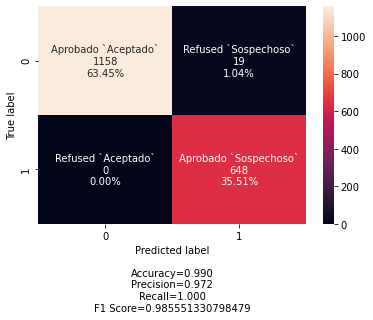

In [36]:
#Evaluamos ahora el modelo sobre una matriz de confusion, que es un metodo donde se grafican los casos predichos contra los reales del set de testing
#de esta forma se pueden ver los errores que tenemos tanto de falsos positivos para los que son en realidad negativos
#como falsos negativos para los que son en realidad positivos
#en estadistica esto se llama error del tipo I y del tipo II

from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['Aprobado `Aceptado`', 'Refused `Sospechoso`', 'Refused `Aceptado`', 'Aprobado `Sospechoso`']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
f1_score  = 2*precision*recall / (precision + recall)
sns.heatmap(cf_matrix, annot=labels, fmt='')
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={}".format(accuracy, precision, recall, f1_score)
plt.ylabel('True label')
plt.xlabel('Predicted label' + stats_text)

Sobre este grafico tenemos tanto los casos, como los errores, y los valores de score: precision, recall y F1 score. este desafio en particular iba a ser evaluado en base al F1 Score. En este caso como nuestro dataset fue resampleado duplicando casos de negativo puede que aunque tengamos un algo valor de precision y muy poco error, en la realidad con datos nuevos no se comporte tan exacto, tambien puede que hayamos sobre ajustado (overfitting) el modelo. Aun no tengo los resultados para orientarme en cuanto a que tan buena podria ser esta solucion en comparacion con el resto de participantes. Tambien sobre esta version modifiqué un par de cosas asi que no es exactamente la misma version con la que participé.

Luego de este paso venía hacer las predicciones del modelo sobre el dataset de evaluacion para enviar como resultados.